# Example Experiments
Compare different low rank svd algorithms.
* Parameters: $n \gg d \gg k \gg 0$.
* Dataset: Synthetic low rank matrix $X \in \R^{n \times d}$.
* Goal: find the first $k$ right singular-vectors $V_k \in \R^{k \times d}$ and singular-values $S \in \R^k$ of $X$.
* Measurements: Running time and error $\|X^T X - S * V_k^T V_k\|_2$.

In [1]:
import math
import numpy as np
import scipy as sp
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from scipy.stats import ortho_group, norm
from pyexpt.expts import Expt

## Implement (or wrap) your datasets and algorithms

In [14]:
# Implement (or wrap) your dataset in a BaseEstimator class.
class LowrankMatrix(BaseEstimator):
    """An example of a BaseEstimator class."""
    def __init__(self, n_samples=100, n_features=10,
            effective_rank=0.1, random_state=None,) -> None:
        super().__init__()
        self.n_samples    = n_samples
        self.n_features   = n_features
        self.effective_rank  = effective_rank
        self.random_state = random_state
        # generate
        self.generator = check_random_state(random_state)
        self.sigmas = np.exp(-np.linspace(0, 1/self.effective_rank, num=self.n_features)**2)
        self.ortho = ortho_group.rvs(self.n_features, random_state=self.generator)
        self.cov = self.ortho.T @ np.diag(self.sigmas) @ self.ortho
        self.X = self.generator.multivariate_normal(np.zeros(self.n_features), self.cov, size=self.n_samples)
        _, self.s, self.Vh = sp.linalg.svd(self.X, full_matrices=False, lapack_driver='gesvd')
        self.XTX = self.X.T @ self.X
    
    def bestLowrank(self, k):
        """Return the best lowrank matrix with rank k."""
        return (self.Vh[:k].T*self.s[:k]) @ self.Vh[:k]
    
    def __str__(self):
        return f"LowRank({self.effective_rank})"

In [3]:
# Implement or wrap your algorithms in a BaseEstimator class.
class MyBaseSVD(BaseEstimator):
    """Base SVD algorithm"""
    def __init__(self, n_components=2, random_state=None,) -> None:
        super().__init__()
        self.n_components = n_components
        self.random_state = random_state
    
    def fit(self, X):
        return self
    
    def __str__(self):
        return f"Base SVD"

class NumpySVD(MyBaseSVD):
    """Wrap Numpy svd implementation."""    
    def fit(self, X):
        _, s, Vh = np.linalg.svd(X, full_matrices=False)
        self.singular_values_ = s[:self.n_components]
        self.components_ = Vh[:self.n_components]
        return self
    
    def __str__(self):
        return f"NumpySVD()"

class ScipySVD(MyBaseSVD):
    """Wrap sklearn TrancatedSVD implementation."""    
    def fit(self, X):
        _, s, Vh = sp.linalg.svd(X, full_matrices=False, lapack_driver='gesvd')
        self.singular_values_ = s[:self.n_components]
        self.components_ = Vh[:self.n_components]
        return self
    
    def __str__(self):
        return f"ScipySVD()"

# This is the scikit-learn implementation of low-rank matrix approximation.
# It is already a BaseEstimator class. So we can just use it.
from sklearn.decomposition import TruncatedSVD

In [4]:
# How do you run your algorithms with your datasets?
def run(alg, data):
    return alg.fit(data.X)

# How do you measure the performance of your algorithms?
def measure(alg, data):
    est = (alg.components_.T*alg.singular_values_) @ alg.components_
    truth = data.bestLowrank(alg.n_components)
    return {'error': np.linalg.norm((truth - est), ord=2)}

## Design your experiment

First experiment is comparing error and time of 3 algorithms on 1 dataset.

In [15]:
n, d, k = 1000, 100, 10
# List of 3 algorithms
algs = [NumpySVD(n_components=k), ScipySVD(n_components=k), TruncatedSVD(n_components=k), TruncatedSVD(n_components=k, algorithm='arpack')]
# List of 1 dataset
datasets = [LowrankMatrix(n_samples=n, n_features=d, effective_rank=0.1)]

expt = Expt(run_func=run, alg_list=algs, data_list=datasets, measure_func=measure)
expt.run().results

,round,data,make_time,alg,init_time,run_time,error,measure_time
0,0,LowRank(0.1),0.051993,NumpySVD(),0.000118,0.013149,1.305706e-13,0.002265
1,0,LowRank(0.1),0.051993,ScipySVD(),0.000155,0.024449,0.000000e+00,0.000370
2,0,LowRank(0.1),0.051993,TruncatedSVD(n_components=10),0.000430,0.138441,1.559564e-07,0.002632
3,0,LowRank(0.1),0.051993,"TruncatedSVD(algorithm='arpack', n_components=10)",0.000458,0.016468,1.190263e-13,0.003003


What suprised me is that TruncatedSVD is slower then other two full SVD algorithm.
Let's try some different parameters of it.

In [16]:
algs = [TruncatedSVD(n_components=k, algorithm='arpack')]
alg_params={'tol': [0.1**(i-3) for i in range(10)]}
Expt(run_func=run, alg_list=algs, data_list=datasets, measure_func=measure, alg_params=alg_params).run().results

,round,data,make_time,alg,init_time,tol,run_time,error,measure_time
0,0,LowRank(0.1),0.056293,"TruncatedSVD(algorithm='arpack', n_components=...",0.000509,1000.000000,0.010584,1.500861e+00,0.004525
1,0,LowRank(0.1),0.056293,"TruncatedSVD(algorithm='arpack', n_components=...",0.000502,100.000000,0.014036,4.922939e-03,0.004481
2,0,LowRank(0.1),0.056293,"TruncatedSVD(algorithm='arpack', n_components=...",0.000513,10.000000,0.013112,2.479216e-02,0.004388
3,0,LowRank(0.1),0.056293,"TruncatedSVD(algorithm='arpack', n_components=...",0.000449,1.000000,0.012640,4.483796e-03,0.004369
4,0,LowRank(0.1),0.056293,"TruncatedSVD(algorithm='arpack', n_components=...",0.000515,0.100000,0.006613,2.269289e-02,0.001700
5,0,LowRank(0.1),0.056293,"TruncatedSVD(algorithm='arpack', n_components=...",0.000494,0.010000,0.007481,1.873345e-11,0.001642
6,0,LowRank(0.1),0.056293,"TruncatedSVD(algorithm='arpack', n_components=...",0.000486,0.001000,0.007091,1.268373e-10,0.001633
7,0,LowRank(0.1),0.056293,"TruncatedSVD(algorithm='arpack', n_components=...",0.000454,0.000100,0.013941,4.284767e-11,0.001694
8,0,LowRank(0.1),0.056293,"TruncatedSVD(algorithm='arpack', n_components=...",0.000574,0.000010,0.007814,3.481466e-10,0.001642
9,0,LowRank(0.1),0.056293,"TruncatedSVD(algorithm='arpack', n_components=...",0.000489,0.000001,0.008555,1.101169e-13,0.001645


In [17]:
algs = [TruncatedSVD(n_components=k)]
alg_params={'n_iter': [i for i in range(10)]}
Expt(run_func=run, alg_list=algs, data_list=datasets, measure_func=measure, alg_params=alg_params).run().results

,round,data,make_time,alg,init_time,n_iter,run_time,error,measure_time
0,0,LowRank(0.1),0.037509,"TruncatedSVD(n_components=10, n_iter=0)",0.000480,0.0,0.014612,4.506998e+00,0.001487
1,0,LowRank(0.1),0.037509,"TruncatedSVD(n_components=10, n_iter=1)",0.000479,1.0,0.005317,1.348293e-01,0.002493
2,0,LowRank(0.1),0.037509,"TruncatedSVD(n_components=10, n_iter=2)",0.000448,2.0,0.009431,1.284645e-03,0.002500
3,0,LowRank(0.1),0.037509,"TruncatedSVD(n_components=10, n_iter=3)",0.000453,3.0,0.012035,1.658404e-04,0.002542
4,0,LowRank(0.1),0.037509,"TruncatedSVD(n_components=10, n_iter=4)",0.000483,4.0,0.016014,8.126918e-07,0.002583
5,0,LowRank(0.1),0.037509,TruncatedSVD(n_components=10),0.000484,5.0,0.018889,3.666206e-08,0.009387
6,0,LowRank(0.1),0.037509,"TruncatedSVD(n_components=10, n_iter=6)",0.000549,6.0,0.062008,2.773584e-09,0.002597
7,0,LowRank(0.1),0.037509,"TruncatedSVD(n_components=10, n_iter=7)",0.000493,7.0,0.016942,8.695594e-10,0.002530
8,0,LowRank(0.1),0.037509,"TruncatedSVD(n_components=10, n_iter=8)",0.000466,8.0,0.017961,7.681181e-12,0.002541
9,0,LowRank(0.1),0.037509,"TruncatedSVD(n_components=10, n_iter=9)",0.000456,9.0,0.019055,2.012528e-12,0.002514


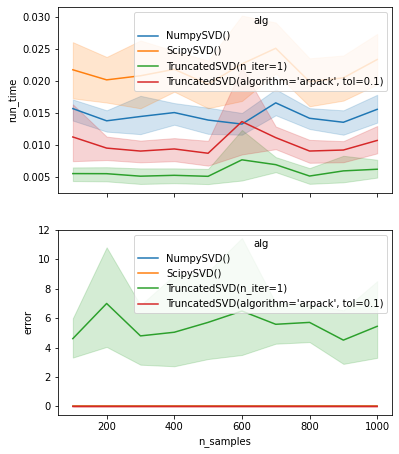

In [18]:
n, d, k = 1000, 100, 2
# List of 3 algorithms
algs = [NumpySVD(n_components=k), ScipySVD(n_components=k), TruncatedSVD(n_components=k, n_iter=1), TruncatedSVD(n_components=k, algorithm='arpack', tol=0.1)]
# List of 1 dataset
datasets = [LowrankMatrix(n_samples=n, n_features=d, effective_rank=0.1)]
data_params={'n_samples': [(i+1)*100 for i in range(10)]}
expt = Expt(run_func=run, alg_list=algs, data_list=datasets,data_params=data_params, measure_func=measure)
expt.run(n_repeat=10).plot(x_list=['n_samples'], y_list=['run_time','error'], group='alg')

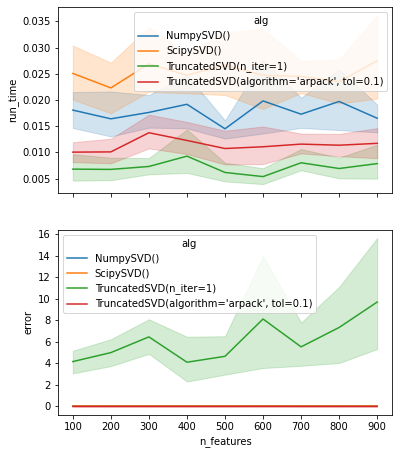

In [21]:
n, d, k = 1000, 100, 2
# List of 3 algorithms
algs = [NumpySVD(n_components=k), ScipySVD(n_components=k), TruncatedSVD(n_components=k, n_iter=1), TruncatedSVD(n_components=k, algorithm='arpack', tol=0.1)]
# List of 1 dataset
datasets = [LowrankMatrix(n_samples=n, n_features=d, effective_rank=0.1)]
data_params={'n_features': [(i+1)*100 for i in range(9)]}
expt = Expt(run_func=run, alg_list=algs, data_list=datasets,data_params=data_params, measure_func=measure)
expt.run(n_repeat=10).plot(x_list=['n_features'], y_list=['run_time','error'], group='alg')